In [97]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2


In [98]:
# img_path = r"C:\TRABAJO\Apps\socks_matcher\socks2.jpeg"
# img_path = r"C:\TRABAJO\Apps\socks_matcher\test1.jpeg"
img_path = r"C:\TRABAJO\Apps\socks_matcher\test2.jpeg"
# img_path = r"C:\TRABAJO\Apps\socks_matcher\test3.jpg"
plot_results = True

# Number of clusters (color words)
color_bins = 10

# Number of clusters (visual words)
num_clusters = 100

color_matches_for_label = 6
shape_matches_for_label = 4



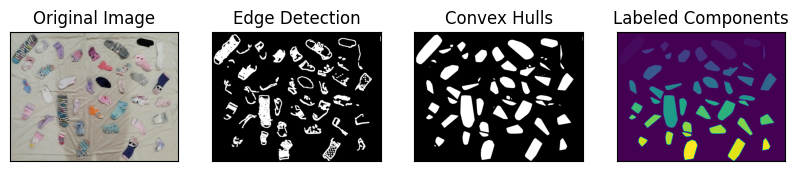

In [99]:
# Step 1: Load the image
image = np.array(Image.open(img_path))

# Step 3: Apply a threshold or edge detection
edges_r = cv2.Canny(image[:,:,0], 50, 200)
edges_g = cv2.Canny(image[:,:,1], 50, 200)
edges_b = cv2.Canny(image[:,:,2], 50, 200)

edges = edges_r | edges_g | edges_b

kernel = np.ones((3, 3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=3)

# Step 4: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Form convex hulls
convex_hulls = [cv2.convexHull(contour) for contour in contours]

# Create an empty mask to draw filled convex hulls
hull_mask = np.zeros_like(image[:,:,0])

# Fill convex hulls on the mask
for hull in convex_hulls:
    cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

# Apply dilation and erosion
hull_mask = cv2.erode(hull_mask, kernel, iterations=3)
dilated_eroded_mask = cv2.dilate(hull_mask, kernel, iterations=0)

# Find convex hulls on each contour after dilation and erosion
contours_after_morph, _ = cv2.findContours(dilated_eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
convex_hulls_after_morph = [cv2.convexHull(contour) for contour in contours_after_morph]

# Create an empty mask to draw filled convex hulls after morphology operations
hull_mask_after_morph = np.zeros_like(image[:,:,0])

# Fill convex hulls on the mask after morphology operations
for hull in convex_hulls_after_morph:
    cv2.drawContours(hull_mask_after_morph, [hull], -1, 255, thickness=cv2.FILLED)

# Step 6: Find connected components in the mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(hull_mask_after_morph)

# Step 7: Retain components with larger area
sorted_areas = np.sort(stats[:, cv2.CC_STAT_AREA])

min_area = 0.05 * sorted_areas[-2]  # Set the minimum area threshold
filtered_mask = np.zeros_like(image[:,:,0])

for i in range(1, num_labels):  # Start from 1 to skip the background
    if stats[i, cv2.CC_STAT_AREA] >= min_area:
        filtered_mask[labels == i] = 255

# Display filtered components on the original image
output_image = 0*image.copy()[:, :, 0]
output_image[filtered_mask == 255] = 255  # Draw in green

# Step 8: Find connected components in the mask
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(output_image)


# Display edge detection result
if plot_results:
    fig, ax = plt.subplots(1,4, figsize=(10,5))
    for _ in ax:
        _.set_xticks([], [])
        _.set_yticks([], [])
    ax[0].imshow(image)
    ax[0].set_title('Original Image')

    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Edge Detection')

    # Display final mask with convex hulls
    ax[2].imshow(hull_mask_after_morph, cmap='gray')
    ax[2].set_title('Convex Hulls')

    ax[3].imshow(labels)
    ax[3].set_title('Labeled Components')

    plt.show()


## Color matching

In [100]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans


def get_representative_color_rgb(hist_h):
    # Encontrar el bin con la mayor frecuencia
    max_bin = np.argmax(hist_h)
    # Calcular el valor del tono correspondiente al bin más frecuente
    hue_value = max_bin * (180 / color_bins)
    # Crear un color HSV representativo (usando saturación y valor máximos para un color puro)
    representative_color_hsv = np.uint8([[[hue_value, 255, 255]]])
    # Convertir el color representativo de HSV a RGB
    representative_color_rgb = cv2.cvtColor(representative_color_hsv, cv2.COLOR_HSV2RGB)[0][0]
    return representative_color_rgb


# def calculate_histograms(image, labels, color_bins: int = 180):
#     # Get unique labels
#     unique_labels = np.unique(labels)

#     # Remove background
#     unique_labels = unique_labels[unique_labels != 0]

#     # Initialize dictionary to hold histograms
#     histograms = {}

#     # Calculate histogram for each label
#     for label in unique_labels:
#         if label == 0:  # Assuming 0 is the background label
#             continue
#         mask = labels == label
#         hist_h = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_RGB2HSV)],[0],mask.astype(np.uint8),[color_bins],[0, 180],)
#         hist_s = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_RGB2HSV)],[1],mask.astype(np.uint8),[color_bins],[0, 256],)
#         hist = np.vstack((hist_h, hist_s))

#         histograms[label] = {"hist": hist.flatten(), "color": get_representative_color_rgb(hist_h)}

#     return histograms


def calculate_BCW(image, labels, color_bins: int = 180):
    """
        Calculate bags of color words (BCW).
    """

    image_subsampled = image.copy()
    image_subsampled = cv2.resize(image_subsampled, (image_subsampled.shape[1]//4, image_subsampled.shape[0]//4))
    labels_subsampled = np.stack((labels, labels, labels), axis=2)
    labels_subsampled = cv2.resize(labels_subsampled, (labels_subsampled.shape[1]//4, labels_subsampled.shape[0]//4), interpolation=cv2.INTER_NEAREST)[:, :,0]
    pixels_at_labels = image_subsampled[labels_subsampled != 0]

    kmeans_colors = KMeans(n_clusters=color_bins, n_init=10).fit(pixels_at_labels)
    # color_words = kmeans_colors.cluster_centers_

    # Initialize dictionary to hold histograms
    histograms = {}
    for label in np.unique(labels):
        color_descriptors = image_subsampled[labels_subsampled == label]
        if len(color_descriptors) > 0:
            words = kmeans_colors.predict(color_descriptors)
            hist, _ = np.histogram(words, bins=np.arange(color_bins + 1))
        else:
            hist = np.zeros(num_clusters)
        histograms[label] = {"hist": hist, "color": get_representative_color_rgb(hist)}
        
    return histograms


def find_best_matches(histograms, color_matches_for_label: int = 10):
    labels = list(histograms.keys())
    histograms_list = [histograms[label]["hist"] for label in labels]
    color_list = [histograms[label]["color"] for label in labels]

    # Calculate pairwise distances
    distances = cdist(histograms_list, histograms_list, metric="cosine")

    # We only need the upper triangle of the distance matrix, excluding the diagonal
    np.fill_diagonal(distances, np.inf)

    # Find the best matches
    best_matches = []
    matches_in_each_label = {_: 0 for _ in labels}
    while np.min(distances) < np.inf:
        min_dist_idx = np.unravel_index(
            np.argmin(distances, axis=None), distances.shape
        )
        distances[min_dist_idx] = np.inf  # Exclude this pair from further consideration

        if (
            matches_in_each_label[labels[min_dist_idx[0]]] < color_matches_for_label
        ) and (
            matches_in_each_label[labels[min_dist_idx[1]]] < color_matches_for_label
        ):
            best_matches.append(
                {
                    "labels": (
                        labels[min_dist_idx[0]],
                        labels[min_dist_idx[1]],
                        distances[min_dist_idx],
                    ),
                    "color": color_list[min_dist_idx[0]],
                }
            )
            matches_in_each_label[labels[min_dist_idx[0]]] += 1
            matches_in_each_label[labels[min_dist_idx[1]]] += 1

    return best_matches

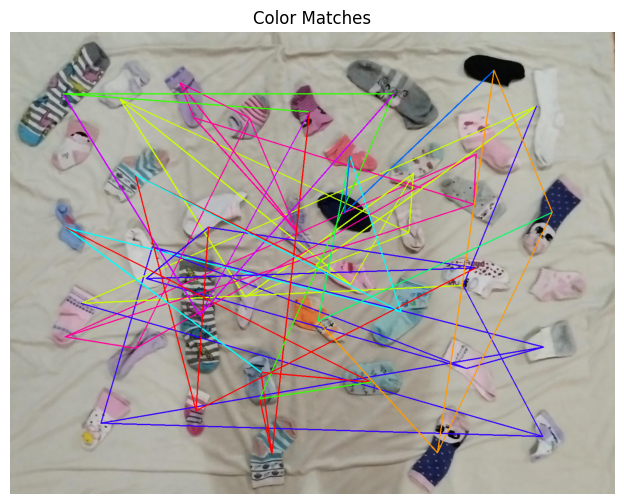

In [101]:
# Calculate histograms
# histograms = calculate_histograms(image, labels, color_bins=color_bins)
histograms = calculate_BCW(image, labels, color_bins=color_bins)

# Find the best matches
color_matches = find_best_matches(histograms, color_matches_for_label=color_matches_for_label)

image_with_lines_color = np.copy(image)  # Make a copy of the grayscale image

thickness = 2
matched_labels = []
for match in color_matches:
    i, j, dist = match['labels'][0], match['labels'][1], match['labels'][2]
    # print(f"Best match between labels {i} and {j} with distance {dist:.2f}")
    line_color = match['color']
    line_color = (int(line_color[0]), int(line_color[1]), int(line_color[2]))
    cv2.line(image_with_lines_color, np.array(centroids[i], dtype=int), np.array(centroids[j], dtype=int), line_color, thickness)


# Display the image with lines between centroids
plt.figure(figsize=(12, 6))
plt.imshow(image_with_lines_color)
plt.axis('off')
plt.title('Color Matches')
plt.show()

# Bag of visual words

In [102]:
keypoints_list = []
descriptors_list = []
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
for label_idx in range(num_labels):
    component_mask = (labels == label_idx).astype(np.uint8)
    if label_idx != 0:
        keypoints = cv2.goodFeaturesToTrack(gray, mask=component_mask, maxCorners=100, qualityLevel=0.01, minDistance=10)
    else:
        keypoints = [np.zeros((1, 2))]
        
    if keypoints is not None:
        keypoints = [cv2.KeyPoint(x[0][0], x[0][1], 1) for x in keypoints]
        keypoints_list.append(keypoints)
        _, descriptors = cv2.SIFT_create().compute(gray, keypoints)
        descriptors_list.append(descriptors)
    else:
        raise ValueError('No features to track')


In [103]:
from sklearn.cluster import KMeans


# Concatenate all descriptors to form a single array for clustering
all_descriptors = np.vstack(descriptors_list)

kmeans = KMeans(n_clusters=num_clusters, n_init=10)
kmeans.fit(all_descriptors)
visual_words = kmeans.cluster_centers_

In [104]:
histograms = []
for descriptors in descriptors_list:
    if len(descriptors) > 0:
        words = kmeans.predict(descriptors)
        hist, _ = np.histogram(words, bins=np.arange(num_clusters + 1))
    else:
        hist = np.zeros(num_clusters)
    histograms.append(hist)

In [105]:
from sklearn.metrics.pairwise import cosine_similarity


# Compute similarity matrix
similarity_matrix = cosine_similarity(histograms)

# Find the top shape_matches_for_label most similar labels for each component, excluding self-matches
shape_matches = []
for i in range(num_labels):
    similarity_matrix[i, i] = -1  # Exclude self-matching by setting the diagonal to a very low value
    # Get indices of the top n most similar components
    most_similar_indices = np.argsort(similarity_matrix[i])[::-1][:shape_matches_for_label]
    shape_matches.append(most_similar_indices)

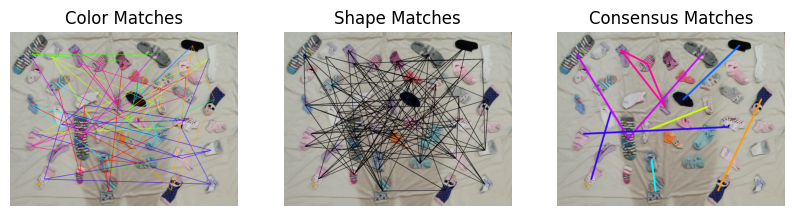

In [106]:
# Draw lines between centroids based on n_matches_norm
image_with_lines_shape = np.copy(image)  # Make a copy of the grayscale image
image_with_lines_both = np.copy(image)
line_color = (0, 0, 0) 
color_matches_labels = [(_['labels'][:2]) for _ in color_matches]


for i in range(num_labels):
    thickness = 2  # Thickness proportional to n_matches_norm
    for j in shape_matches[i]:
        cv2.line(image_with_lines_shape, np.array(centroids[i], dtype=int), np.array(centroids[j], dtype=int), (0,0,0), thickness)
        if (i, j) in color_matches_labels or (j, i) in color_matches_labels:
            try:
                color_ind = color_matches_labels.index((i, j))
            except ValueError:
                color_ind = color_matches_labels.index((j, i))
            line_color = color_matches[color_ind]['color']
            line_color = (int(line_color[0]), int(line_color[1]), int(line_color[2]))
            cv2.line(image_with_lines_both, np.array(centroids[i], dtype=int), np.array(centroids[j], dtype=int), line_color, 5*thickness)


# Display the image with lines between centroids
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(image_with_lines_color)
ax[0].axis('off')
ax[0].set_title('Color Matches')
ax[1].imshow(image_with_lines_shape)
ax[1].axis('off')
ax[1].set_title('Shape Matches')
ax[2].imshow(image_with_lines_both)
ax[2].axis('off')
ax[2].set_title('Consensus Matches')
plt.show()